In [1]:
%matplotlib inline

In [21]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
import matplotlib

In [3]:
mypath = '/raid/yifan/RBM/Measured_stratified_temp_from_TVA/measured_data'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [8]:
raw = pd.read_fwf('/raid3/rniemeyr/RBM/two_layer_model/RBM_Yixin/RIPS/model_run/source/VIC_RBM/src/fort.32', \
            header = None)

In [9]:
raw.index = pd.date_range('1949-01-02','2010-12-31')
raw.columns = ['time', 'T_epil_res1' , 'T_epil_res2' , 'T_epil_res3' , 'T_epil_res4' , 'T_hypo_res1' , 'T_hypo_res2' , 'T_hypo_res3' , 'T_hypo_res4' ]
raw = raw.drop('time',1)

In [10]:
temp_measure = pd.DataFrame()
temp_model = pd.DataFrame()

for j in range(len(onlyfiles)):
#for j in [0]:
    print(j)
    filename = mypath + '/' + onlyfiles[j]
    x = pd.ExcelFile(filename)
    sheet_name = x.sheet_names
    
#    plt.figure(figsize=[10,6])
#    plt.xlabel('Temperature(' + r"$^o$" + 'C)', fontsize = 10)
#    plt.ylabel('Depth (m)')
#    plt.gca().invert_yaxis()
    
    for i in range(len(sheet_name)):
    #for i in range(4):
#    for i in [0]:
        data = x.parse(sheet_name[i], skiprows = [0,2], header = [0])
        if any(np.isnan(data['Temp'])):
            data = data.dropna()
#        f, = plt.plot(data['Temp'],data['Depth'],label = i,linewidth = 2)
#        f.set_label(i)
#        plt.legend()
        str1 = sheet_name[i]
        a = re.findall('\d+', str1 )
        T_top    = data['Temp'].iloc[-1]
        T_bottom = data['Temp'].iloc[0]
        
        if (T_top - T_bottom < 2):
            T_epil_measure = data['Temp'].iloc[-1]
            T_hypo_measure = data['Temp'].iloc[0]
        
        else: 
            A = np.array(data['Depth'].loc[data['Temp'] >=T_top -2])
            B = np.array(data['Depth'].loc[data['Temp'] < T_top -2])
            T_epil_measure = ((A - np.concatenate([A[1:],[0]]))*np.array(data['Temp'].loc[data['Temp'] >=T_top -2])).sum()/A[0]
            T_hypo_measure = ((B - np.concatenate([B[1:],[A[0]]]))*np.array(data['Temp'].loc[data['Temp'] < T_top -2])).sum()/(B[0] - A[0])
        
        index = pd.datetime(int(a[0]),int(a[1]),int(a[2]))
        New_measure = pd.DataFrame([[T_epil_measure,T_hypo_measure]],index = [index],columns=['T_epil','T_hypo'])
        temp_measure = pd.concat([temp_measure,New_measure])

        New_model = raw[raw.index == pd.datetime(int(a[0]),int(a[1]),int(a[2]))]
        temp_model = pd.concat([temp_model,New_model])

0
1
2
3
4
5
6
7
8
9
10
11


In [11]:
combine_temp = pd.concat([temp_model,temp_measure],  axis = 1).dropna(axis = 0)

In [12]:
T_epil_model = combine_temp['T_epil_res4'].values
T_hypo_model = combine_temp['T_hypo_res4'].values
T_epil_measure = combine_temp['T_epil'].values
T_hypo_measure = combine_temp['T_hypo'].values

# analysis

In [60]:
#Linear regressison -polyfit - polyfit can be used other orders polys
(ar,br)=polyfit(T_epil_measure,T_epil_model,1)
xr=polyval([ar,br],T_epil_measure)
#compute the mean square error
err=sqrt(sum((xr-T_epil_measure)**2)/len(T_epil_measure))


(ar1,br1)=polyfit(T_hypo_measure,T_hypo_model,1)
xr1=polyval([ar1,br1],T_hypo_measure)
#compute the mean square error
err1=sqrt(sum((xr1-T_hypo_measure)**2)/len(T_hypo_measure))


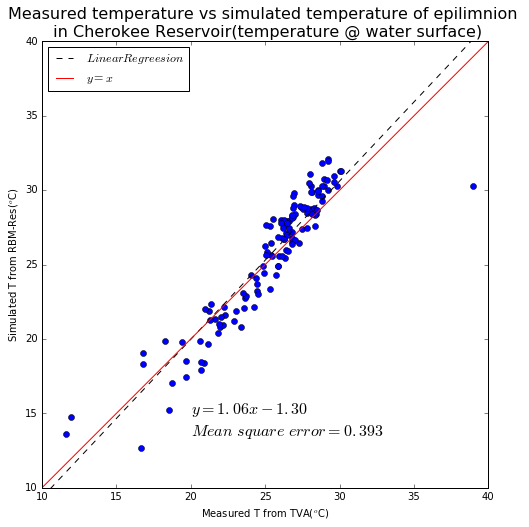

In [69]:
plt.figure(figsize=[8,8])
plt.plot(T_epil_measure,T_epil_model,'bo')
f1, = plt.plot([10,40],polyval([ar,br],[10,40]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f2, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of epilimnion \n in Cherokee Reservoir(temperature @ water surface)', fontsize = 16)
plt.legend(handles = [f1,f2],loc = 0)
plt.text(20,15,'$y = %s x %s$'%("{0:.2f}".format(ar),"{0:.2f}".format(br)), fontsize=16)
plt.text(20,13.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err)),fontsize=16)
plt.xlim(10,40)
plt.ylim(10,40)
plt.savefig('Tepil_measured-simulated_cherokee.png', dpi=300, bbox_inches='tight')

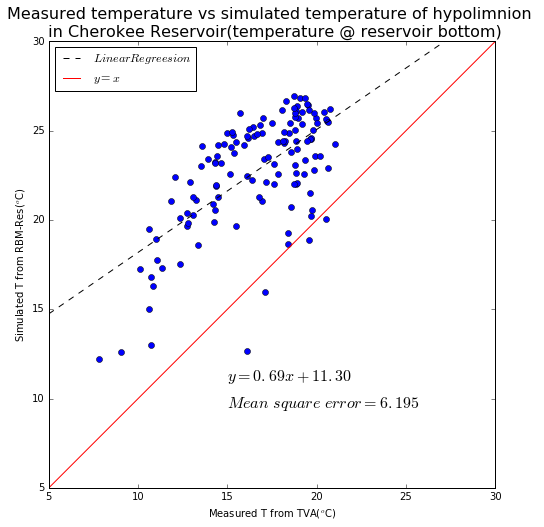

In [68]:
plt.figure(figsize=[8,8])
plt.plot(T_hypo_measure,T_hypo_model,'o')
f3, = plt.plot([5,30],polyval([ar1,br1],[5,30]),'k--', label = '$Linear Regreesion$')
plt.ylabel('Simulated T from RBM-Res('+r"$^o$"+'C)')
plt.xlabel('Measured T from TVA('+ r"$^o$"+'C)')
f4, = plt.plot([0,40],[0,40],'r-', label = r"$y = x$")
plt.title('Measured temperature vs simulated temperature of hypolimnion \n in Cherokee Reservoir(temperature @ reservoir bottom)', fontsize = 16)
plt.legend(handles = [f3,f4],loc = 0)
plt.text(15,11,'$y = %s x +%s$'%("{0:.2f}".format(ar1),"{0:.2f}".format(br1)), fontsize=16)
plt.text(15,9.5,'$Mean\ square\ error = %s$'%("{0:.3f}".format(err1)),fontsize=16)
plt.xlim(5,30)
plt.ylim(5,30)
plt.savefig('Thypo_measured-simulated_cherokee_mean.png', dpi=300, bbox_inches='tight')

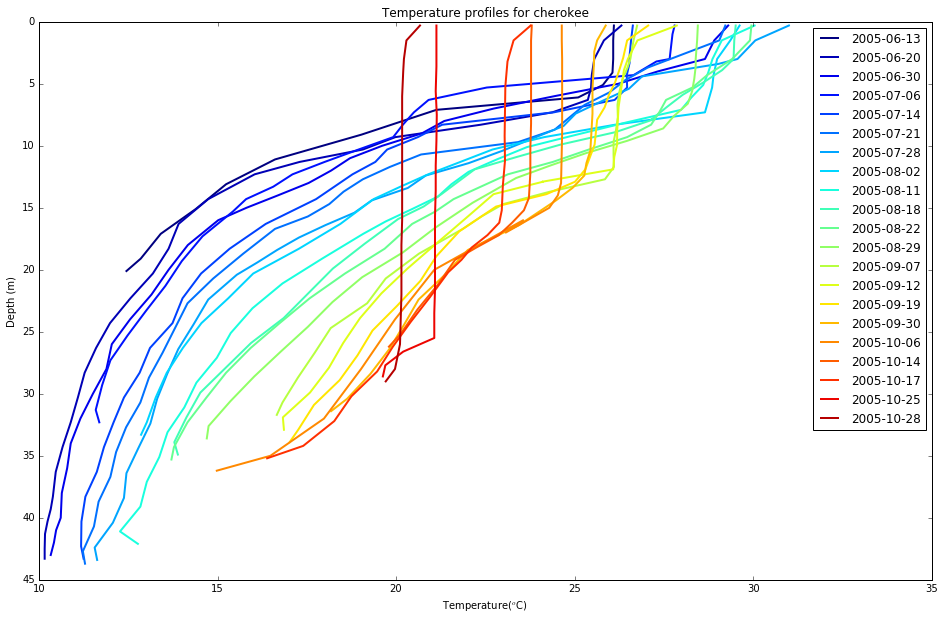

In [30]:
for j in [1]:

    filename = mypath + '/' + onlyfiles[j]
    x = pd.ExcelFile(filename)
    sheet_name = x.sheet_names
    
    plt.figure(figsize=[16,10])
    plt.xlabel('Temperature(' + r"$^o$" + 'C)', fontsize = 10)
    plt.ylabel('Depth (m)')
    plt.gca().invert_yaxis()
    plt.title('Temperature profiles for cherokee')
    cmap = matplotlib.cm.get_cmap('jet')
    for i in range(len(sheet_name)):
    #for i in range(4):
    #for i in [5]:
        data = x.parse(sheet_name[i], skiprows = [0,2], header = [0])
        f, = plt.plot(data['Temp'],data['Depth'],label = i,linewidth = 2,color = cmap(i/len(sheet_name)))
        str1 = sheet_name[i]
        a = re.findall('\d+', str1 )
        legend_date = a[0]+'-'+a[1]+'-'+a[2]
        f.set_label(legend_date)
        plt.legend(loc=0)

    plt.savefig('measured_temperature_profiles.png', bbox_inche = 'tight', dpi = 300)

In [19]:

cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba)

(0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)
